In [1]:
import pandas as pd
import numpy as np

In [2]:
loans = pd.read_csv('lending-club-data.csv', low_memory=False)

In [3]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

target = 'safe_loans'
loans = loans[features + [target]]

In [4]:
loans.head()

,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1


In [5]:
train_index = pd.read_json('module-8-assignment-2-train-idx.json')
train_index.columns = ['indexvalue']
train_idx = train_index.indexvalue.tolist()

test_index = pd.read_json('module-8-assignment-2-test-idx.json')
test_index.columns = ['indexvalue']
test_idx = test_index.indexvalue.tolist()

train_data = loans.iloc[train_idx]
test_data = loans.iloc[test_idx]

In [6]:
train_data.shape, test_data.shape, loans.shape

((37224, 5), (9284, 5), (122607, 5))

In [7]:
print train_data['safe_loans'].value_counts()
print test_data['safe_loans'].value_counts()

 1    18748
-1    18476
Name: safe_loans, dtype: int64
-1    4674
 1    4610
Name: safe_loans, dtype: int64


In [8]:
def df_encode_data(data, categorical_type):
    return pd.get_dummies(data[categorical_type])

In [9]:
category = features

X_train_vector = df_encode_data(train_data[features], features)
X_test_vector = df_encode_data(test_data[features], features)

In [10]:
# there is no numerical feature in this case
X_train = X_train_vector
X_test = X_test_vector
y_train = train_data[target]
y_test = test_data[target]

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37224, 25), (37224,), (9284, 25), (9284,))

In [12]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    label_positive_index = list(np.where(labels_in_node == +1)[0])
    #print +1, len(label_positive_index)
    total_weight_positive = sum(data_weights[label_positive_index])
    #total_weight_positive = sum(data_weights[np.where(labels_in_node == +1)])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    label_negative_index = list(np.where(labels_in_node == -1)[0])
    #print +1, len(label_negative_index)
    total_weight_negative = sum(data_weights[label_negative_index])
    #total_weight_negative = sum(data_weights[np.where(labels_in_node == -1)])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    #print total_weight_positive, total_weight_negative
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_positive > weighted_mistakes_all_negative:
        #print weighted_mistakes_all_negative, -1
        return (weighted_mistakes_all_negative, -1)
    else:
        #print weighted_mistakes_all_positive, +1
        return (weighted_mistakes_all_positive, +1)
        

In [13]:
example_labels = np.array([-1, -1, 1, 1, 1])
example_data_weights = np.array([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print 'Test passed!'
else:
    print 'Test failed... try again!'

Test passed!


In [14]:
# If the data is identical in each feature, this function should return None
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        #print feature, len(left_split), len(right_split)
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[list(np.where(data[feature] == 0)[0])]
        right_data_weights = data_weights[list(np.where(data[feature] == 1)[0])]
        
        #print feature, len(left_data_weights), len(right_data_weights), sum(left_data_weights), sum(right_data_weights)
        
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = float(left_weighted_mistakes + right_weighted_mistakes) / float(sum(data_weights))
        
        #print feature, error, data_weights
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [15]:
training_data = pd.concat([X_train,y_train],axis=1)
updated_features = training_data.columns[:-1].tolist()

In [16]:
data_weights = np.array(len(training_data)* [1.5])

In [17]:
example_data_weights = np.array(len(training_data)* [1.5])
if best_splitting_feature(training_data, updated_features, target, example_data_weights) == 'term_ 36 months':
    print 'Test passed!'
else:
    print 'Test failed... try again!'

Test passed!


In [18]:
features

['grade', 'term', 'home_ownership', 'emp_length']

In [19]:
# Leaf structure
#{ 
#   'is_leaf'            : True/False.
#   'prediction'         : Prediction at the leaf node.
#   'left'               : (dictionary corresponding to the left tree).
#   'right'              : (dictionary corresponding to the right tree).
#   'splitting_feature'  : The feature that this node splits on.
#}

def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class ## YOUR CODE HERE
    
    return leaf

In [20]:
#Now write a function that learns a weighted decision tree recursively and implements 3 stopping conditions:

# - All data points in a node are from the same class.
# - No more features to split on.
# - Stop growing the tree when the tree depth reaches max_depth.

def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print "Stopping condition 2 reached."                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    #print splitting_feature, remaining_features
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[list(np.where(data[splitting_feature] == 0)[0])]
    right_data_weights = data_weights[list(np.where(data[splitting_feature] == 1)[0])]
    
    print "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [21]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [22]:
example_data_weights = np.array([1.0 for i in range(len(training_data))])
small_data_decision_tree = weighted_decision_tree_create(training_data, updated_features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print 'Test passed!'
else:
    print 'Test failed... try again!'
    print 'Number of nodes found:', count_nodes(small_data_decision_tree)
    print 'Number of nodes that should be there: 7' 

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade_D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data po

In [23]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 'splitting_feature': 'term_ 36 months'}

In [24]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [25]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [26]:
testing_data = pd.concat([X_train,y_train],axis=1)

In [27]:
testing_data.head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,...,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,safe_loans
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,-1
6,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,-1
7,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,-1
10,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,-1
12,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,-1


In [28]:
evaluate_classification_error(small_data_decision_tree, testing_data)

0.40003761014399314

In [29]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(training_data, updated_features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [30]:
print 'Classification errors: %s percent' % evaluate_classification_error(small_data_decision_tree_subset_20, training_data)

Classification errors: 0.481248656781 percent


In [31]:
#pred = training_data.apply(lambda x: classify(small_data_decision_tree_subset_20, x), axis=1)

In [32]:
def print_stump(tree, name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('_')
    print '                       %s' % name
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]               [{0} == 1]    '.format(split_name)
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

In [33]:
small_data_decision_tree_subset_20

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_F'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 'splitting_feature': 'home_ownership_RENT'}

In [34]:
print_stump(small_data_decision_tree_subset_20['left'], small_data_decision_tree_subset_20['splitting_feature'])

                       home_ownership_RENT
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_F == 0]               [grade_F == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: 1)                         (leaf, label: -1)


In [35]:
# Implementing Adaboost

Implementing your own Adaboost (on decision stumps)
Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with decision tree stumps by training trees with max_depth=1.
Recall from the lecture the procedure for Adaboost:
1. Start with unweighted data with $\alpha_j = 1$
2. For t = 1,...T:
Learn $f_t(x)$ with data weights $\alpha_j$
Compute coefficient $\hat{w}_t$: $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
Re-compute weights $\alpha_j$: $$\alpha_j \gets \begin{cases}
 \alpha_j \exp{(-\hat{w}_t)} &amp; \text{ if }f_t(x_j) = y_j\\
 \alpha_j \exp{(\hat{w}_t)} &amp; \text{ if }f_t(x_j) \neq y_j
 \end{cases}$$
Normalize weights $\alpha_j$: $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$

In [47]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'Adaboost Iteration %d' % t
        print '====================================================='        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        #predictions = data.apply(lambda x: classify(tree_stump, x))
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        #print len(is_wrong[is_wrong == True]), len(alpha[np.where(is_wrong)])
        weighted_error = sum(alpha[np.where(is_wrong)])/sum(alpha)
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = 1./2. * log((1 - weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = np.array(is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight)))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        ## YOUR CODE HERE 
        #print alpha
        #print adjustment
        alpha = (alpha*adjustment)/float(sum(alpha))
    
    return weights, tree_stumps

In [48]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(training_data, updated_features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


Reminders

    Stump weights (ŵ) and data point weights (α) are two different concepts.
    Stump weights (ŵ) tell you how important each stump is while making predictions with the entire boosted ensemble.
    Data point weights (α) tell you how important each data point is while training a decision stump.

In [49]:
stump_weights

[0.15802933659263743, 0.17682363293605327]

In [50]:
tree_stumps

[{'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'term_ 36 months'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_A'}]

In [51]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(training_data, updated_features, target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

In [52]:
stump_weights

[0.15802933659263743,
 0.17682363293605327,
 0.09311888971195705,
 0.0728888552581495,
 0.06706306914131716,
 0.06456916961613322,
 0.05456055779221647,
 0.04351093673354489,
 0.028988711500059067,
 0.0259625096913776]

In [53]:
tree_stumps

[{'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'term_ 36 months'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_A'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'home_ownership_MORTGAGE'},
 {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting

In [54]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        weighted_predictions = stump_weights[i] * predictions
        #print weighted_predictions.shape, scores.shape, predictions.shape
        #print predictions.iloc[:10]
        scores = scores + weighted_predictions
        #print scores.shape
        
    #return scores.apply(lambda score : +1 if score > 0 else -1)
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [58]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(training_data, updated_features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

In [59]:
from sklearn.metrics import accuracy_score

error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], training_data)
    error = 1.0 - accuracy_score(training_data[target], predictions)
    error_all.append(error)
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.433430045132
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.400037610144
Iteration 5, training error = 0.384724908661
Iteration 6, training error = 0.384617451107
Iteration 7, training error = 0.382763808296
Iteration 8, training error = 0.384617451107
Iteration 9, training error = 0.382763808296
Iteration 10, training error = 0.384483129164
Iteration 11, training error = 0.382736943907
Iteration 12, training error = 0.381447453256
Iteration 13, training error = 0.381528046422
Iteration 14, training error = 0.380560928433
Iteration 15, training error = 0.380507199656
Iteration 16, training error = 0.378223726628
Iteration 17, training error = 0.378277455405
Iteration 18, training error = 0.378411777348
Iteration 19, training error = 0.378062540297
Iteration 20, training error = 0.378761014399
Iteration 21, training error = 0.379566946056
Iteration 22, training error = 0.3788953363

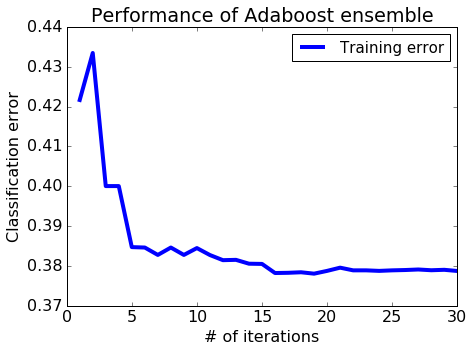

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [62]:
test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], testing_data)
    test_error = 1.0 - accuracy_score(testing_data[target], predictions)
    test_error_all.append(test_error)
    print "Iteration %s, training error = %s" % (n, test_error_all[n-1])

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.433430045132
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.400037610144
Iteration 5, training error = 0.384724908661
Iteration 6, training error = 0.384617451107
Iteration 7, training error = 0.382763808296
Iteration 8, training error = 0.384617451107
Iteration 9, training error = 0.382763808296
Iteration 10, training error = 0.384483129164
Iteration 11, training error = 0.382736943907
Iteration 12, training error = 0.381447453256
Iteration 13, training error = 0.381528046422
Iteration 14, training error = 0.380560928433
Iteration 15, training error = 0.380507199656
Iteration 16, training error = 0.378223726628
Iteration 17, training error = 0.378277455405
Iteration 18, training error = 0.378411777348
Iteration 19, training error = 0.378062540297
Iteration 20, training error = 0.378761014399
Iteration 21, training error = 0.379566946056
Iteration 22, training error = 0.3788953363

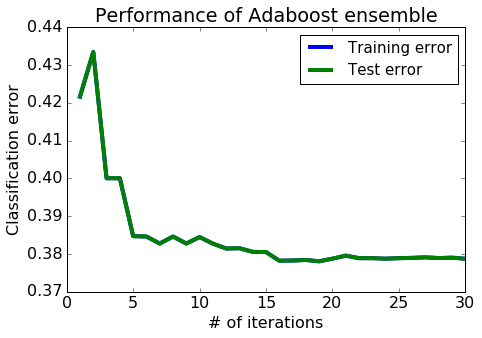

In [67]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()